## Loading Dataset

We will use The 20 Newsgroups dataset 
Dataset [homepage](http://qwone.com/~jason/20Newsgroups/): 

Scikit-learn includes some nice helper functions for retrieving the 20 Newsgroups dataset-- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html. We'll use them below to retrieve the dataset.

Also look at results fron non- neural net models here : https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py



In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 8.1MB/s 
     |████████████████████████████████| 2.9MB 39.4MB/s 
     |████████████████████████████████| 890kB 24.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b2aa34486492d08311edeba2f749a015074c06c577e7185c875106a6aa87ae0e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split 
from keras.models import Sequential 
from keras.layers import Dense, Dropout 
np.random.seed(0) 
from pathlib import Path
import nltk
from sklearn import preprocessing
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
from datetime import datetime
from pathlib import Path
import pandas as pd
import torch.nn.functional as F
import torchtext.data as ttd
import transformers as ppb

In [ ]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

In [ ]:
print(train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [ ]:
print(train.target[0])

7


In [ ]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
len(train.target_names)

20

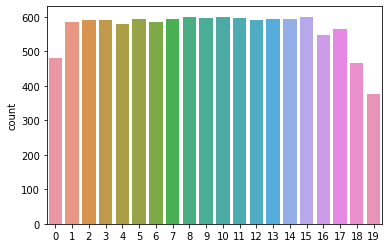

In [ ]:
import seaborn as sns

# Plot the number of tokens of each length.
sns.countplot(train.target);

In [ ]:
#Saving Data into Dataframe
train = pd.DataFrame([train.data, train.target.tolist()]).T
train.columns = ['text', 'target']
test = pd.DataFrame([test.data, test.target.tolist()]).T
test.columns = ['text', 'target']
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   target  11314 non-null  object
dtypes: object(2)
memory usage: 176.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7532 entries, 0 to 7531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7532 non-null   object
 1   target  7532 non-null   object
dtypes: object(2)
memory usage: 117.8+ KB


In [ ]:
train.target.unique()

array([7, 4, 1, 14, 16, 13, 3, 2, 8, 19, 6, 0, 12, 5, 10, 9, 15, 17, 18,
       11], dtype=object)

In [ ]:
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)

# Task 1- Experiment 1

## Tokenization- Task 1 A

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[:max_length-2]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

### RNN function

In [ ]:
class RNN(nn.Module):
    def __init__(self, bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate):
      super(RNN, self).__init__()
      self.D = bert_model.config.to_dict()['hidden_size']
      self.bert_model = bert_model
      
      self.M = n_hidden
      self.K = n_outputs
      self.L = n_rnnlayers
      self.num_diections= bidirectional
      self.dropout_rate=dropout_rate
      

      
      # rnn layers
      self.rnn = nn.LSTM(
          input_size=self.D,
          hidden_size=self.M,
          num_layers=self.L,
          bidirectional=self.num_diections,
          dropout= self.dropout_rate,
          batch_first=True)
      
      # dense layer
      self.fc = nn.Linear(self.M *2 , self.K)

      # dropout layer
      self.dropout= nn.Dropout(self.dropout_rate)
    
    def forward(self, X):
      # initial hidden states
      h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
      c0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)


      with torch.no_grad():
        embedding = self.bert_model(X)[0][:,1:,:]

      embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

      # get RNN unit output
      output, (hidden,cell) = self.rnn(embedding, (h0, c0))



      # max pool
      output, _ = torch.max(output, 1)
      output= self.dropout(output)
      # we only want h(T) at the final time step
      output = self.fc(output)
      return output  

### **BERT** Model

In [ ]:
 from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1a.pt')  

Epoch 5/5, Train Loss: 1.8713    Valid Loss: 1.2992, Duration: 0:07:25.556759


Train acc: 0.5418,	 Valid acc: 0.5475,	 Test acc: 0.5169


## Tokenization Task-1 B

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

### Truncating sequence length to 128 tokens

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[:128-2]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1b.pt')  

Epoch 5/5, Train Loss: 1.7744    Valid Loss: 1.3200, Duration: 0:01:52.326694


Train acc: 0.5708,	 Valid acc: 0.5444,	 Test acc: 0.5319


## Tokenization Task-1 C

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

### Truncate sequence length to 140 tokens

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[:140-2]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1c.pt')  

Epoch 5/5, Train Loss: 1.8199    Valid Loss: 1.3075, Duration: 0:02:08.855693


Train acc: 0.5676,	 Valid acc: 0.5541,	 Test acc: 0.5327


## Tokenization Task-1 D a)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[-(512-2):]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1da.pt')  

Epoch 5/5, Train Loss: 1.8935    Valid Loss: 1.3229, Duration: 0:07:29.703213


Train acc: 0.5209,	 Valid acc: 0.5135,	 Test acc: 0.4926


## Tokenization Task-1 D b)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[-(128-2):]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1db.pt')  

Epoch 5/5, Train Loss: 1.8446    Valid Loss: 1.3997, Duration: 0:01:53.406713


Train acc: 0.5268,	 Valid acc: 0.5210,	 Test acc: 0.4944


## Tokenization Task-1 D c)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[-(140-2):]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1dc.pt')  

Epoch 5/5, Train Loss: 1.8393    Valid Loss: 1.4000, Duration: 0:02:09.478683


Train acc: 0.5334,	 Valid acc: 0.5276,	 Test acc: 0.5066


## Tokenization Task-1 E a)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:256-1]
    tokens2 = tokens[-(256-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1ea.pt')  

Epoch 5/5, Train Loss: 1.9144    Valid Loss: 1.3593, Duration: 0:08:09.085311


Train acc: 0.5322,	 Valid acc: 0.5303,	 Test acc: 0.5005


## Tokenization Task-1 E b)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:64-1]
    tokens2 = tokens[-(64-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1eb.pt')  

Epoch 5/5, Train Loss: 1.7493    Valid Loss: 1.2400, Duration: 0:01:56.164750


Train acc: 0.5955,	 Valid acc: 0.5851,	 Test acc: 0.5647


## Tokenization Task-1 E c)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:70-1]
    tokens2 = tokens[-(70-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1ec.pt')  

Epoch 5/5, Train Loss: 1.7707    Valid Loss: 1.2479, Duration: 0:02:12.147152


Train acc: 0.5828,	 Valid acc: 0.5722,	 Test acc: 0.5516


## Task-1 F

In [ ]:
def chunking(data_frame):
  #ccreate data frame for chunks
  chunks = pd.DataFrame()
  chunks['text'] = [] 
  chunks['target'] = [] 
  
  
  for k in range(0,len(data_frame)):
    
    if len(data_frame.text[k]) > 140:
      list = [data_frame.text[k][i: i + 140] for i in range(0, len(data_frame.text[k]), 140)]
      
      for j in range(0,len(list)):
        chunks = chunks.append({'text' : list[j]  ,  'target': data_frame.target[k]}, 
                  ignore_index = True)
   

  
  chunks.target = chunks.target.astype(int)
  return chunks

In [ ]:
train_chunking = chunking(train)
train_chunking.head()
test_chunking = chunking(test)
test_chunking.head()


,text,target
0,I am a little confused on all of the models of...,7
1,erences are far as features or performance. I ...,7
2,than book value can you usually get them for....,7
3,g\nearly summer is the best time to buy.,7
4,I'm not familiar at all with the format of the...,5


In [ ]:
train_chunking.to_csv("train_final.csv",index=False)
test_chunking.to_csv("test_final.csv",index=False)

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens = tokens[:max_length-2]
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
    train_dataset = ttd.TabularDataset(
        'train_final.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test_final.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


### BERT Model

In [ ]:
 from transformers import  BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1f.pt')  


Epoch 5/5, Train Loss: 1.9068    Valid Loss: 1.3343, Duration: 0:07:45.576905


Train acc: 0.5357,	 Valid acc: 0.5422,	 Test acc: 0.5101


In [ ]:
train_chunking = chunking(train)
train_chunking.head()
test_chunking = chunking(test)
test_chunking.head()


,text,target
0,I am a little confused on all of the models of...,7
1,erences are far as features or performance. I ...,7
2,than book value can you usually get them for....,7
3,g\nearly summer is the best time to buy.,7
4,I'm not familiar at all with the format of the...,5


In [ ]:
train_chunking.to_csv("train_final.csv",index=False)
test_chunking.to_csv("test_final.csv",index=False)

# Task 1- Experiment 2

## Tokenization- Task 1 a

In [ ]:
  from transformers import BertTokenizer
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:70-1]
    tokens2 = tokens[-(70-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])




In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

#### Defining the RNN function

In [ ]:
class RNN(nn.Module):
    def __init__(self, bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate):
      super(RNN, self).__init__()
      self.D = bert_model.config.to_dict()['hidden_size']
      self.bert_model = bert_model
      
      self.M = n_hidden
      self.K = n_outputs
      self.L = n_rnnlayers
      self.num_diections= bidirectional
      self.dropout_rate=dropout_rate
      

      
      # rnn layers
      self.rnn = nn.LSTM(
          input_size=self.D,
          hidden_size=self.M,
          num_layers=self.L,
          bidirectional=self.num_diections,
          dropout= self.dropout_rate,
          batch_first=True)
      
      # dense layer
      self.fc = nn.Linear(self.M *2 , self.K)

      # dropout layer
      self.dropout= nn.Dropout(self.dropout_rate)
    
    def forward(self, X):
      # initial hidden states
      h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
      c0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)


      with torch.no_grad():
        embedding = self.bert_model(X)[0][:,1:,:]

      embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

      # get RNN unit output
      output, (hidden,cell) = self.rnn(embedding, (h0, c0))



      # max pool
      output, _ = torch.max(output, 1)
      output= self.dropout(output)
      # we only want h(T) at the final time step
      output = self.fc(output)
      return output  

#### BERT Model

In [ ]:
from transformers import  BertModel
from transformers import get_linear_schedule_with_warmup
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) ## 5



  ## 6. Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 33

  #early stop para,eters
patience = 5
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0.001  

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_iter) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
    
  t0= datetime.now()
  train_loss=[]
    
  model.train()
  for batch in train_iter:
    
      # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

      # backward pass
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_loss.append(loss.item())
    
  train_loss=np.mean(train_loss)
        
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in valid_iter:
  
        # forward pass
      output= model(batch.data)
      loss=criterion(output,batch.label)
        
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
    
    # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
    #print(scheduler)
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 

    ## Early Stopping
  score = -valid_loss

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(),'tuned_bert.pt')
      valid_loss_min = valid_loss
        
  elif score < best_score + delta:
      counter_early_stop += 1
      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      if counter_early_stop >= patience:
          early_stop = True
  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(),'tuned_bert.pt')
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break
  



  #load model
model.load_state_dict(torch.load('tuned_bert.pt'))
train_acc = get_accuracy(train_iter, model)
valid_acc = get_accuracy(valid_iter, model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')




Epoch 1/33, Train Loss: 1.8177    Valid Loss: 1.4162, Duration: 0:02:17.977619
Validation loss decreased (inf --> 1.416152).  Saving model ...
Epoch 2/33, Train Loss: 1.2211    Valid Loss: 1.1603, Duration: 0:02:17.296153
Validation loss decreased (1.416152 --> 1.160272).  Saving model ...
Epoch 3/33, Train Loss: 1.0363    Valid Loss: 1.0394, Duration: 0:02:17.467400
Validation loss decreased (1.160272 --> 1.039366).  Saving model ...
Epoch 4/33, Train Loss: 0.9046    Valid Loss: 1.0349, Duration: 0:02:17.325978
Validation loss decreased (1.039366 --> 1.034854).  Saving model ...
Epoch 5/33, Train Loss: 0.7935    Valid Loss: 1.0429, Duration: 0:02:17.375532
Early Stopping counter: 1 out of 5
Epoch 6/33, Train Loss: 0.7001    Valid Loss: 1.0007, Duration: 0:02:17.285221
Validation loss decreased (1.034854 --> 1.000709).  Saving model ...
Epoch 7/33, Train Loss: 0.6231    Valid Loss: 1.0121, Duration: 0:02:17.325661
Early Stopping counter: 1 out of 5
Epoch 8/33, Train Loss: 0.5253    Val

# Task 1- Experiment 3

#### For this experiment, we have considered these two variations of BERT from Huggingface library : Roberta and MobileBERT

## Running Roberta without fine tuning

In [ ]:
  from transformers import RobertaTokenizer
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:70-1]
    tokens2 = tokens[-(70-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])

In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import RobertaModel
bert_model = RobertaModel.from_pretrained('roberta-base')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1ec.pt')  

Epoch 5/5, Train Loss: 2.0210    Valid Loss: 1.4290, Duration: 0:02:19.126410


Train acc: 0.4935,	 Valid acc: 0.4896,	 Test acc: 0.4772


## Running Fine tuned model - Roberta

In [ ]:
from transformers import RobertaModel

In [ ]:
  from transformers import RobertaTokenizer
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  max_length = tokenizer.model_max_length
  max_length

512

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:70-1]
    tokens2 = tokens[-(70-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])

In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

In [ ]:
class RNN(nn.Module):
    def __init__(self, bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate):
      super(RNN, self).__init__()
      self.D = bert_model.config.to_dict()['hidden_size']
      self.bert_model = bert_model
      
      self.M = n_hidden
      self.K = n_outputs
      self.L = n_rnnlayers
      self.num_diections= bidirectional
      self.dropout_rate=dropout_rate
      

      
      # rnn layers
      self.rnn = nn.LSTM(
          input_size=self.D,
          hidden_size=self.M,
          num_layers=self.L,
          bidirectional=self.num_diections,
          dropout= self.dropout_rate,
          batch_first=True)
      
      # dense layer
      self.fc = nn.Linear(self.M *2 , self.K)

      # dropout layer
      self.dropout= nn.Dropout(self.dropout_rate)
    
    def forward(self, X):
      # initial hidden states
      h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
      c0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)


      with torch.no_grad():
        embedding = self.bert_model(X)[0][:,1:,:]

      embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

      # get RNN unit output
      output, (hidden,cell) = self.rnn(embedding, (h0, c0))



      # max pool
      output, _ = torch.max(output, 1)
      output= self.dropout(output)
      # we only want h(T) at the final time step
      output = self.fc(output)
      return output  

### Roberta Model

In [ ]:
from transformers import RobertaModel
from transformers import get_linear_schedule_with_warmup
bert_model = RobertaModel.from_pretrained('roberta-base')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) ## 5



  ## 6. Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 33

  #early stop para,eters
patience = 5
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0.001  

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_iter) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
    
  t0= datetime.now()
  train_loss=[]
    
  model.train()
  for batch in train_iter:
    
      # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

      # backward pass
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_loss.append(loss.item())
    
  train_loss=np.mean(train_loss)
        
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in valid_iter:
  
        # forward pass
      output= model(batch.data)
      loss=criterion(output,batch.label)
        
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
    
    # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
    #print(scheduler)
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 

    ## Early Stopping
  score = -valid_loss

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(),'tuned_bert.pt')
      valid_loss_min = valid_loss
        
  elif score < best_score + delta:
      counter_early_stop += 1
      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      if counter_early_stop >= patience:
          early_stop = True
  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(),'tuned_bert.pt')
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break
  



  #load model
model.load_state_dict(torch.load('tuned_bert.pt'))
train_acc = get_accuracy(train_iter, model)
valid_acc = get_accuracy(valid_iter, model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')


Epoch 1/33, Train Loss: 1.9895    Valid Loss: 1.3830, Duration: 0:02:19.569034
Validation loss decreased (inf --> 1.382996).  Saving model ...
Epoch 2/33, Train Loss: 1.3634    Valid Loss: 1.2364, Duration: 0:02:18.860085
Validation loss decreased (1.382996 --> 1.236416).  Saving model ...
Epoch 3/33, Train Loss: 1.1812    Valid Loss: 1.1305, Duration: 0:02:18.937191
Validation loss decreased (1.236416 --> 1.130453).  Saving model ...
Epoch 4/33, Train Loss: 1.0298    Valid Loss: 1.0170, Duration: 0:02:18.920303
Validation loss decreased (1.130453 --> 1.017023).  Saving model ...
Epoch 5/33, Train Loss: 0.9139    Valid Loss: 1.0299, Duration: 0:02:18.799384
Early Stopping counter: 1 out of 5
Epoch 6/33, Train Loss: 0.8252    Valid Loss: 1.0881, Duration: 0:02:18.647260
Early Stopping counter: 2 out of 5
Epoch 7/33, Train Loss: 0.7331    Valid Loss: 1.0142, Duration: 0:02:18.805738
Validation loss decreased (1.017023 --> 1.014225).  Saving model ...
Epoch 8/33, Train Loss: 0.6573    Val

## Running MobileBert without fine tuning

In [ ]:
!pip install SentencePiece

     |████████████████████████████████| 1.1MB 15.7MB/s 


In [ ]:
% pip install sentencepiece

In [ ]:
% pip install transformers sentencepiece

In [ ]:
  from transformers import MobileBertTokenizer
  tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
  max_length = tokenizer.model_max_length

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:70-1]
    tokens2 = tokens[-(70-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])

In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
from transformers import MobileBertModel
bert_model = MobileBertModel.from_pretrained('google/mobilebert-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) 



  #Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 5


  # STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

  # STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 
  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):

    
  t0= datetime.now()
  train_loss=[]
    
model.train()
for batch in train_iter:
          
      # forward pass
  output= model(batch.data)
  loss=criterion(output,batch.label)

      # set gradients to zero 
  optimizer.zero_grad()

      # backward pass
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
    
train_loss=np.mean(train_loss)
        
valid_loss=[]
model.eval()
with torch.no_grad():
  for batch in valid_iter:
  
        # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)
        
    valid_loss.append(loss.item())

  valid_loss=np.mean(valid_loss)
    
    # save Losses
train_losses[epoch]= train_loss
valid_losses[epoch]= valid_loss
dt= datetime.now()-t0
print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 
train_acc = get_accuracy(train_iter,model)
valid_acc = get_accuracy(valid_iter,model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')
torch.save(model.state_dict(), 'model_1ec.pt')  

Epoch 5/5, Train Loss: 1.6932    Valid Loss: 1.3212, Duration: 0:01:17.333682


Train acc: 0.5656,	 Valid acc: 0.5563,	 Test acc: 0.5360


## Running Fine tuned model - MobileBert

In [ ]:
from transformers import MobileBertModel

In [ ]:
  from transformers import MobileBertTokenizer
  tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
  max_length = tokenizer.model_max_length

In [ ]:
def bert_tokenizer(x):
    tokens = tokenizer.tokenize(x) 
    tokens1 = tokens[:70-1]
    tokens2 = tokens[-(70-1):]
    tokens=tokens1+tokens2
    return tokens

In [ ]:
n_hidden = 256 
n_rnnlayers = 3 
n_outputs =20 
bidirectional = True 
dropout_rate = 0.2 

In [ ]:
TEXT = ttd.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = bert_tokenizer,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)
LABEL = ttd.LabelField()

In [ ]:
train_dataset = ttd.TabularDataset(
        'train.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)])

In [ ]:
import csv

In [ ]:
csv.field_size_limit(100000000)
test_dataset = ttd.TabularDataset(
        'test.csv',
        format='csv',
        skip_header=True,
        fields=[('data', TEXT), ('label', LABEL)]
    )    

In [ ]:
import random
SEED=123
training_dataset, validation_dataset = train_dataset.split(split_ratio=0.8, random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(training_dataset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_iter, valid_iter, test_iter  = ttd.BucketIterator.splits((training_dataset,validation_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(16,128,128), 
                              device=device)

cuda:0


In [ ]:
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

In [ ]:
class RNN(nn.Module):
    def __init__(self, bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate):
      super(RNN, self).__init__()
      self.D = bert_model.config.to_dict()['hidden_size']
      self.bert_model = bert_model
      
      self.M = n_hidden
      self.K = n_outputs
      self.L = n_rnnlayers
      self.num_diections= bidirectional
      self.dropout_rate=dropout_rate
      

      
      # rnn layers
      self.rnn = nn.LSTM(
          input_size=self.D,
          hidden_size=self.M,
          num_layers=self.L,
          bidirectional=self.num_diections,
          dropout= self.dropout_rate,
          batch_first=True)
      
      # dense layer
      self.fc = nn.Linear(self.M *2 , self.K)

      # dropout layer
      self.dropout= nn.Dropout(self.dropout_rate)
    
    def forward(self, X):
      # initial hidden states
      h0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)
      c0 = torch.zeros(self.L*2, X.size(0), self.M).to(device)


      with torch.no_grad():
        embedding = self.bert_model(X)[0][:,1:,:]

      embedding= self.dropout(embedding) # (batch_size, sentence_length, emd_dim)

      # get RNN unit output
      output, (hidden,cell) = self.rnn(embedding, (h0, c0))



      # max pool
      output, _ = torch.max(output, 1)
      output= self.dropout(output)
      # we only want h(T) at the final time step
      output = self.fc(output)
      return output  

### MobileBert Model

In [ ]:
from transformers import MobileBertModel
from transformers import get_linear_schedule_with_warmup
bert_model = MobileBertModel.from_pretrained('google/mobilebert-uncased')
bert_model

model = RNN(bert_model, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model.to(device) ## 5



  ## 6. Training loop
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs= 33

  #early stop para,eters
patience = 5
counter_early_stop = 0
best_score = None
early_stop = False
valid_loss_min = np.Inf
delta=0.001  

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_iter) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



  # STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
    
  t0= datetime.now()
  train_loss=[]
    
  model.train()
  for batch in train_iter:
    
      # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

      # backward pass
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_loss.append(loss.item())
    
  train_loss=np.mean(train_loss)
        
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in valid_iter:
  
        # forward pass
      output= model(batch.data)
      loss=criterion(output,batch.label)
        
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
    
    # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
    #print(scheduler)
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}') 

    ## Early Stopping
  score = -valid_loss

  if best_score is None:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(),'tuned_bert.pt')
      valid_loss_min = valid_loss
        
  elif score < best_score + delta:
      counter_early_stop += 1
      print(f'Early Stopping counter: {counter_early_stop} out of {patience}')
      if counter_early_stop >= patience:
          early_stop = True
  else:
      best_score = score
      print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(),'tuned_bert.pt')
      counter_early_stop = 0
      valid_loss_min = valid_loss

  if early_stop:
    print("Early stopping")
    break
  



  #load model
model.load_state_dict(torch.load('tuned_bert.pt'))
train_acc = get_accuracy(train_iter, model)
valid_acc = get_accuracy(valid_iter, model)
test_acc = get_accuracy(test_iter ,model)
print("\n")
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')



Epoch 1/33, Train Loss: 1.6963    Valid Loss: 1.3182, Duration: 0:01:17.463451
Validation loss decreased (inf --> 1.318207).  Saving model ...
Epoch 2/33, Train Loss: 1.2602    Valid Loss: 1.2128, Duration: 0:01:17.254967
Validation loss decreased (1.318207 --> 1.212790).  Saving model ...
Epoch 3/33, Train Loss: 1.1140    Valid Loss: 1.1541, Duration: 0:01:17.280456
Validation loss decreased (1.212790 --> 1.154071).  Saving model ...
Epoch 4/33, Train Loss: 1.0428    Valid Loss: 1.0748, Duration: 0:01:17.190335
Validation loss decreased (1.154071 --> 1.074802).  Saving model ...
Epoch 5/33, Train Loss: 0.9697    Valid Loss: 1.0684, Duration: 0:01:17.220394
Validation loss decreased (1.074802 --> 1.068407).  Saving model ...
Epoch 6/33, Train Loss: 0.8901    Valid Loss: 1.0545, Duration: 0:01:17.109693
Validation loss decreased (1.068407 --> 1.054536).  Saving model ...
Epoch 7/33, Train Loss: 0.8380    Valid Loss: 1.0514, Duration: 0:01:17.205409
Validation loss decreased (1.054536 -